In [38]:
from astropy.table import Table
import matplotlib.pyplot as plt
plt.clf()
plt.cla()
plt.close()
#Clears figure and erases it so that figures can be made later
import math
import numpy
import time
import sklearn
from sklearn.neighbors import NearestNeighbors
import scipy
from scipy  import spatial
from numpy import loadtxt
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas
#Imports possibly useful Python software to use
t=Table.read('NGC2264TGAS.vot')
#Defines t as the data table
def Assignments(Table):
    #Assigns variables from table columns and prints columns to see what there is
    #Parameter Table is the table of data
    print("The columns within this catalog are: ")
    print(t.colnames)
    #Prints out all of the column names for easy reference
    StarRA=t["RA_ICRS"]
    StarDec=t["DE_ICRS"]
    #Reads in the RA and Dec from columns in the table
    Gmag=t["__Gmag_"]
    Parallax=t["Plx"]
    ParallaxError=t["e_Plx"]
    #Reads in quantities from the data table
    return (StarRA,StarDec,Gmag,Parallax,ParallaxError);
StarRA,StarDec,Gmag,Parallax,ParallaxError=Assignments(t)

The columns within this catalog are: 
['_Glon', '_Glat', '_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Epoch', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__Gmag_', 'GLON', 'GLAT']


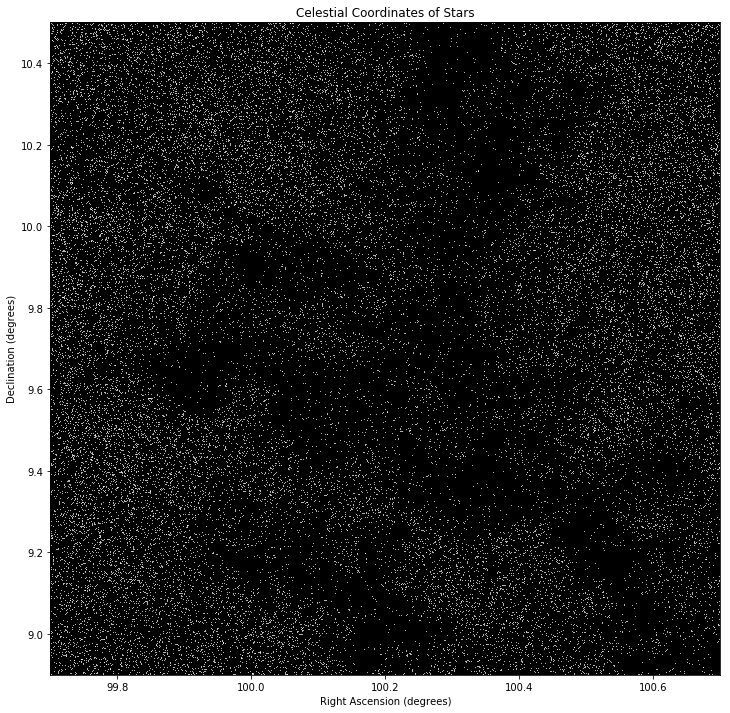

In [39]:
RAMin=99.70
RAMax=100.70
DecMin=8.90
DecMax=10.50
def SkyRegionPlot(StarRA,StarDec,RAMin,RAMax,DecMin,DecMax):
    #Creates a plot (picture) of the locations of stars in this region of sky
    #Parameter StarRA is the star right ascension array
    #Parameter StarDec is the star declination array
    #Parameter RAMin is the minimum right ascension limit
    #Parameter RAMax is the maximum right ascension limit
    #Parameter DecMin is the minimum declination limit
    #Parameter DecMax is the maximum declination limit
    plt.rcParams['axes.facecolor']='black'
    plt.rcParams['figure.figsize']=12,12
    #Sets background color and figure size
    plt.plot(StarRA,StarDec,color='xkcd:white',linestyle='None',marker='*',markersize=0.2)
    #Plots coordinates as white stars with no lines
    plt.xlabel('Right Ascension (degrees)')
    plt.ylabel('Declination (degrees)')
    plt.title('Celestial Coordinates of Stars')
    #Adds appropriate labels and title
    plt.xlim([RAMin,RAMax])
    plt.ylim([DecMin,DecMax])
    #Changes the plot limits to cut off edges
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    #Clears figure and erases it so that figures can be made later
SkyRegionPlot(StarRA,StarDec,RAMin,RAMax,DecMin,DecMax)
#Runs function for NGC 2264

In [40]:
def PixelSetup(StarRA,StarDec,N):
    #Does math to shift and normalize arrays and makes pixels
    #Parameter StarRA is array of the star right ascensions
    #Parameter StarDec is array of the star declinations
    #Parameter N is the number of pixels desired on each side
    RAStDev=numpy.std(StarRA)
    DecStDev=numpy.std(StarDec)
    #Computes standard deviations of each array
    RAAverage=numpy.average(StarRA)
    DecAverage=numpy.average(StarDec)
    #Computes averages of each array
    RA=StarRA-RAAverage
    RA=RA/RAStDev
    Dec=StarDec-DecAverage
    Dec=Dec/DecStDev
    #Shifts and normalizes the RA and Dec so they are easy to work with
    RAPixels=numpy.linspace(RAMin,RAMax,N)
    DecPixels=numpy.linspace(DecMin,DecMax,N)
    #Creates linearly spaced pixel arrays for next step
    RAPixels=RAPixels-RAAverage
    RAPixels=RAPixels/RAStDev
    DecPixels=DecPixels-DecAverage
    DecPixels=DecPixels/DecStDev
    #Shifts and normalizes pixels to match format
    Pixels2D=numpy.zeros([N,N])
    #Makes two-dimensional pixels array for next steps
    RAPixels=numpy.asarray(RAPixels)
    DecPixels=numpy.asarray(DecPixels)
    return (RAStDev,DecStDev,RAAverage,DecAverage,RA,Dec,RAPixels,DecPixels,Pixels2D)
N=100
RAStDev,DecStDev,RAAverage,DecAverage,RA,Dec,RAPixels,DecPixels,Pixels2D=PixelSetup(StarRA,StarDec,N)

In [41]:
def NearestNeighbor2D(k):
    #Finds kth nearest neighbors in two dimensions for star array and pixel grid
    #Parameter k is kth neighbor desired
    tic=time.time()
    #Gets starting time
    Gridx=numpy.array([])
    Gridy=numpy.array([])
    #Makes empty arrays for grid values
    rows=N*N
    for i in range(0,N):
        for j in range(0,N):
            Gridx=numpy.append(Gridx,RAPixels[i])
    for i in range(0,N):
        Gridy=numpy.append(Gridy,DecPixels)
    Grid=numpy.vstack((Gridx,Gridy))
    Grid=numpy.transpose(Grid)
    #Sets up the pixel grid for calculation
    StarArray2D=numpy.vstack((RA,Dec))
    StarArray2D=numpy.transpose(StarArray2D)
    #Sets up the star array for calculation
    tree=spatial.cKDTree(StarArray2D)
    #Sets up the cKDTree structure to query through
    NumberOfNeighbors=k
    #Redefines the number of neighbors as k for function usage
    distance,indices=tree.query(Grid,k=[NumberOfNeighbors])
    #Uses cKDTree algorithm to get kth nearest neighbor distances and indices
    print('Done')
    toc=time.time()
    #Gets final time
    ElapsedTime=toc-tic
    ElapsedTimeMinutes=ElapsedTime/60
    print('Elapsed Time:',ElapsedTime,'seconds')
    print('Elapsed Time:',ElapsedTimeMinutes,'minutes')
    #Shows how long the function took
    return (distance,indices);
k=5
distance,indices=NearestNeighbor2D(k)

Done
Elapsed Time: 0.10034465789794922 seconds
Elapsed Time: 0.0016724109649658204 minutes


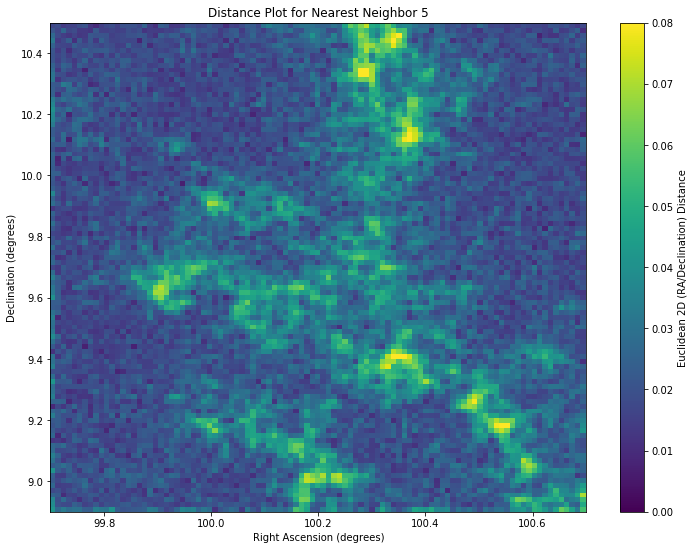

In [42]:
def DistanceMap2D():
    #Produces two-dimensional distance map with color bar and color mapping for kth nearest neighbor distances
    x=numpy.linspace(RAMin,RAMax,N)
    y=numpy.linspace(DecMin,DecMax,N)
    X,Y=numpy.meshgrid(x,y)
    #Creates grid of the original RA and Dec range
    plt.rcParams['figure.figsize']=12,9
    #Sets figure size
    distances=distance[:,0]
    Distances=numpy.reshape(distances,(-1,N))
    Distances=numpy.transpose(Distances)
    #Sets up the nearest neighbor distances for the plot
    plt.pcolormesh(X,Y,Distances,cmap='viridis',vmin=0,vmax=0.08)
    plt.xlabel('Right Ascension (degrees)')
    plt.ylabel('Declination (degrees)')
    plt.title('Distance Plot for Nearest Neighbor %g'%(k))
    #Sets appropriate labels and title and plots with color mapping
    cbar=plt.colorbar()
    cbar.set_label('Euclidean 2D (RA/Declination) Distance',rotation='90')
    #Makes a color bar with label
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    #Clears figure and erases it so that figures can be made later
    return Distances;
Distances=DistanceMap2D()

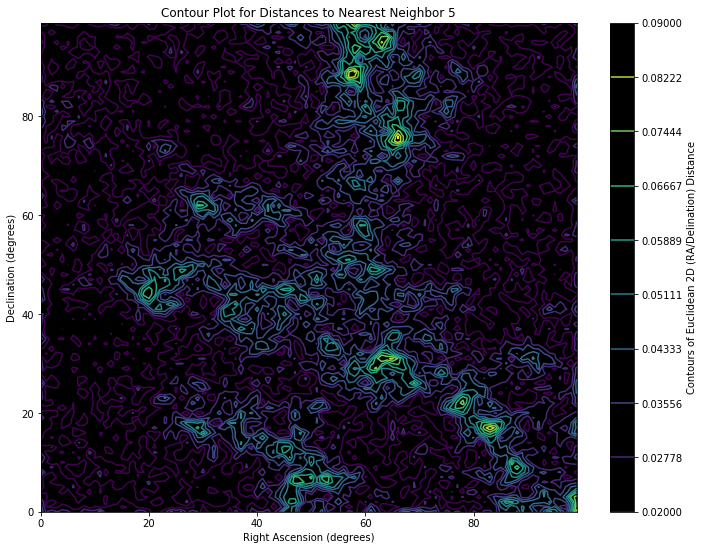

In [43]:
def DistanceMapContour2D(n):
    #Produces contour distance map of the kth nearest neighbor distances
    #Parameter n is number of contours desired
    MinimumLevel=numpy.min(Distances)
    MaximumLevel=numpy.max(Distances)
    AverageLevel=numpy.average(Distances)
    #Gets information on levels for contours
    V=numpy.linspace(0.02,0.09,n)
    #Makes vector for contour levels
    plt.rcParams['figure.figsize']=12,9
    #Sets figure size
    plt.contour(Distances,V)
    cbar=plt.colorbar()
    cbar.set_label('Contours of Euclidean 2D (RA/Delination) Distance',rotation='90')
    plt.title('Contour Plot for Distances to Nearest Neighbor %g'%(k))
    plt.xlabel('Right Ascension (degrees)')
    plt.ylabel('Declination (degrees)')
    #Makes contour plot with color bar and title
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    #Clears figure and erases it so that figures can be made later
n=10
DistanceMapContour2D(n)

In [44]:
def SpectralDistances(M):
    #Computes the distances to stars using spectral assumption
    #Parameter M is the absolute magnitude assumed to be the same for all stars
    IntermediateStep=(1/5)*(Gmag-M+5)
    tens=10*numpy.ones(len(Gmag))
    tens=numpy.transpose(tens)
    StarDistance=numpy.power(tens,IntermediateStep)
    #Calculates distance using magnitude formula assuming all have the same absolute magnitude M
    SpectralDistanceSpecial=numpy.array([])
    for i in range(0,len(StarDistance)):
        if StarDistance[i]<=1000:
            SpectralDistanceSpecial=numpy.append(SpectralDistanceSpecial,StarDistance[i])
        if StarDistance[i]>1000:
            StarDistance[i]=1e4
    #Creates special array of spectral distances at or closer than 1,000 pc and sets those >1,000 pc to 10,000 pc for later
    DistanceAverage=numpy.average(SpectralDistanceSpecial)
    DistanceStDev=numpy.std(SpectralDistanceSpecial)
    Distance=StarDistance-DistanceAverage
    Distance=Distance/DistanceStDev
    #Shifts and normalizes the distance star array like RA and Dec were
    return (StarDistance,DistanceAverage,DistanceStDev,Distance);
#Average absolute magnitude of F spectral type stars taken to be +2.6 in visual (G applies here)
#Uncertainty in this absolute F magnitude is 0.9 magnitudes
#http://adsabs.harvard.edu/full/1966AJ.....71..517M
M=2.6
StarDistance,DistanceAverage,DistanceStDev,Distance=SpectralDistances(M)

In [70]:
def NearestNeighbor3D(k,DistanceMin,DistanceMax,RA,Dec,Distance):
    #Finds the kth nearest neighbor distances and indices in three dimensions using cKDTree algorithm
    #Parameter k is kth nearest neighbor desired
    #Parameter DistanceMin is the minimum distance of the range
    #Parameter DistanceMax is the maximum distance of the range
    #Parameter RA is the shifted and normalized star RA array
    #Parameter Dec is the shifted and normalized star declination array
    #Parameter Distance is the shifted and normalized star distance array
    tic=time.time()
    #Gets starting time
    DistancePixels=numpy.linspace(DistanceMin,DistanceMax,N)
    DistancePixels=DistancePixels-DistanceAverage
    DistancePixels=DistancePixels/DistanceStDev
    DistancePixels=numpy.asarray(DistancePixels)
    #Produces distance pixel array
    Pixels=numpy.zeros([N,N,N])
    StarArray=numpy.vstack((RA,Dec,Distance))
    StarArray=numpy.transpose(StarArray)
    #Prepares star location three dimensional array
    NumberOfPoints=N*N*N
    PixelArray=numpy.zeros((NumberOfPoints,3))
    i=0
    for RA in RAPixels:
        for Dec in DecPixels:
            for Distance in DistancePixels:
                PixelArray[i,0]=RA
                PixelArray[i,1]=Dec
                PixelArray[i,2]=Distance
                i+=1
    #Prepares pixel grid three dimensional array
    tree=spatial.cKDTree(StarArray)
    #Sets up the cKDTree structure to query through
    NumberOfNeighbors=k
    #Redefines the number of neighbors as k for function usage
    Distances3D,Indices3D=tree.query(PixelArray,k=[NumberOfNeighbors])
    #Uses cKDTree algorithm to get kth nearest neighbor distances and indices
    print('Done')
    toc=time.time()
    #Gets final time
    ElapsedTime=toc-tic
    ElapsedTimeMinutes=ElapsedTime/60
    print('Elapsed Time:',ElapsedTime,'seconds')
    print('Elapsed Time:',ElapsedTimeMinutes,'minutes')
    #Shows how long the function took to run
    return (DistancePixels,StarArray,NumberOfPoints,Distances3D,Indices3D);
DistanceMin=0
DistanceMax=1000
DistancePixels,StarArray,NumberOfPoints,Distances3D,Indices3D=NearestNeighbor3D(k,DistanceMin,DistanceMax,RA,Dec,Distance)

Done
Elapsed Time: 2.513002872467041 seconds
Elapsed Time: 0.041883381207784016 minutes


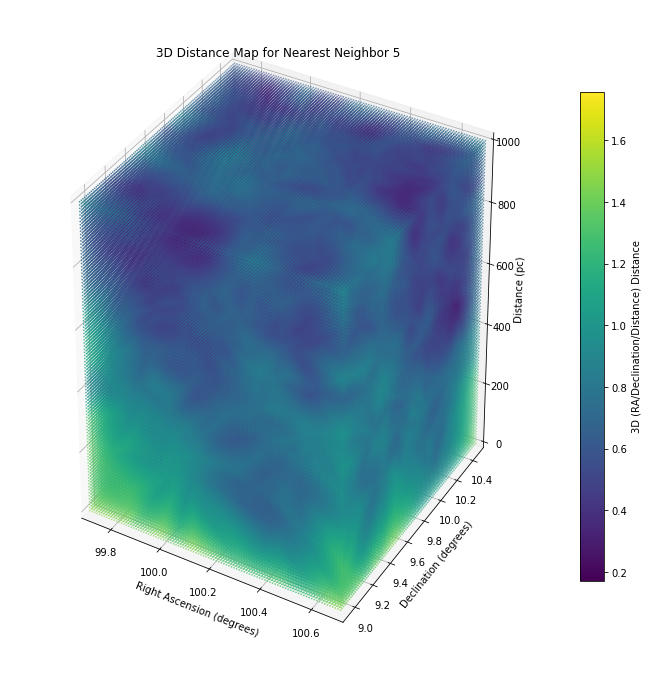

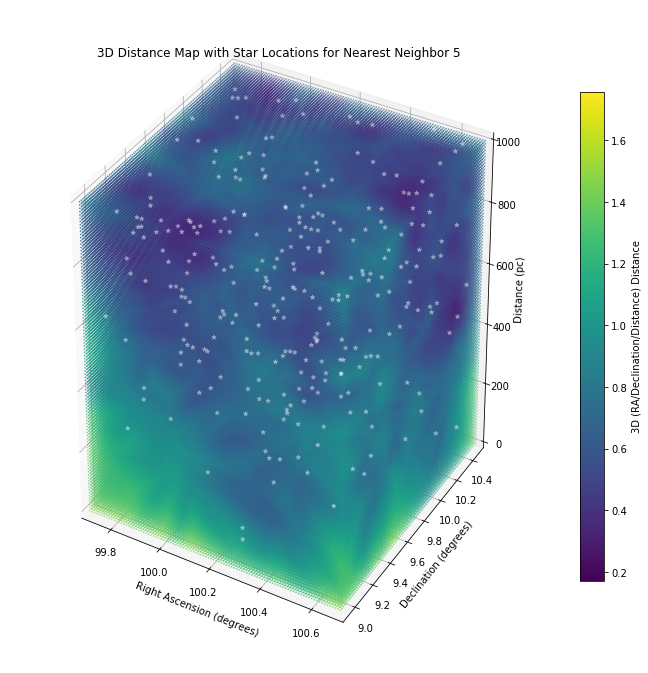

Elapsed Time: 124.45326280593872 seconds
Elapsed Time: 2.0742210467656452 minutes


In [74]:
def DistanceMap3D(Distances3D):
    #Creates the three-dimensional kth nearest neighbor distance arrays needed and plots in 3D the distance map
    #Also creates three-dimensional plot of star locations for comparison and combines these plots
    #Parameter Distances3D is the sequence of three-dimensional kth nearest neighbor distances
    tic=time.time()
    #Gets starting time
    fig=plt.figure()
    ax=plt.axes(projection='3d')
    #Sets up a new figure and establishes the settings as three-dimensional
    x=numpy.linspace(RAMin,RAMax,N)
    y=numpy.linspace(DecMin,DecMax,N)
    z=numpy.linspace(DistanceMin,DistanceMax,N)
    #Making fresh array of linearly spaced points for each axis
    PlotPixelArray=numpy.zeros((NumberOfPoints,3))
    #Creates list with 3 columns to be used for plotting later
    i=0
    for RA in x:
        for Dec in y:
            for Distance in z:
                PlotPixelArray[i,0]=RA
                PlotPixelArray[i,1]=Dec
                PlotPixelArray[i,2]=Distance
                i+=1
    X=PlotPixelArray[:,0]
    Y=PlotPixelArray[:,1]
    Z=PlotPixelArray[:,2]
    #Uses a loop to cycle through all grid points and makes X, Y, and Z vectors to plot
    Pixels=numpy.zeros([N,N,N])
    #Makes 3D grid array of zeros
    for RA in range(0,N):
        for Dec in range(0,N):
            for Distance in range(0,N):
                Pixels[RA,Dec,Distance]=Distances3D[RA+Dec+Distance]
    #Sets as each element in the 3D grid array the kth nearest neighbor distance
    plt.rcParams['figure.figsize']=12,12
    plt.rcParams['axes.facecolor']='white'
    #Sets the figure size and background color
    Distances3D=numpy.ndarray.flatten(Distances3D)
    #Flattens the distances array into a one-dimensional vector for use as a color mapping
    Map3D=ax.scatter3D(X,Y,Z,c=Distances3D,cmap='viridis',marker='o',s=0.5,depthshade=True)
    #Plots in 3D the vectors with the color map as the kth nearest neighor distance with opacity varying to show depth
    plt.title('3D Distance Map for Nearest Neighbor %g'%(k))
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_xlim([RAMin,RAMax])
    ax.set_ylabel('Declination (degrees)')
    ax.set_ylim([DecMin,DecMax])
    ax.set_zlabel('Distance (pc)')
    ax.set_zlim([DistanceMin,DistanceMax])
    #Makes appropriate title, axis labels, and limits for variables
    cbar=fig.colorbar(Map3D,shrink=0.75)
    cbar.set_label('3D (RA/Declination/Distance) Distance',rotation='90')
    #Adds a color bar for the 3D distance, labels it, and rotates the label
    plt.show()
    fig=plt.figure()
    ax=plt.axes(projection='3d')
    #Creates another new figure and reestablishes 3D axis settings
    plt.rcParams['figure.figsize']=12,12
    plt.rcParams['axes.facecolor']='white'
    ax.scatter3D(X,Y,Z,c=Distances3D,cmap='viridis',marker='o',s=0.5,depthshade=True)
    #Plots in 3D the vectors with the color map as the kth nearest neighor distance with opacity varying to show depth
    cbar=fig.colorbar(Map3D,shrink=0.75)
    cbar.set_label('3D (RA/Declination/Distance) Distance',rotation='90')
    #Adds a color bar for the 3D distance, labels it, and rotates the label
    ax.scatter3D(StarRA,StarDec,StarDistance,c='xkcd:white',marker='*',s=20,depthshade=True)
    #Plots the three-dimensional position of all stars as white stars with opacity varying to show depth
    plt.title('3D Distance Map with Star Locations for Nearest Neighbor %g'%(k))
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_xlim([RAMin,RAMax])
    ax.set_ylabel('Declination (degrees)')
    ax.set_ylim([DecMin,DecMax])
    ax.set_zlabel('Distance (pc)')
    ax.set_zlim([DistanceMin,DistanceMax])
    #Makes appropriate title, axis labels, and limits for variables
    plt.show()
    toc=time.time()
    #Gets final time
    ElapsedTime=toc-tic
    ElapsedTimeMinutes=ElapsedTime/60
    print('Elapsed Time:',ElapsedTime,'seconds')
    print('Elapsed Time:',ElapsedTimeMinutes,'minutes')
    #Shows how long the function took to run
    return (PlotPixelArray,X,Y,Z,Pixels)
PlotPixelArray,X,Y,Z,Pixels=DistanceMap3D(Distances3D)

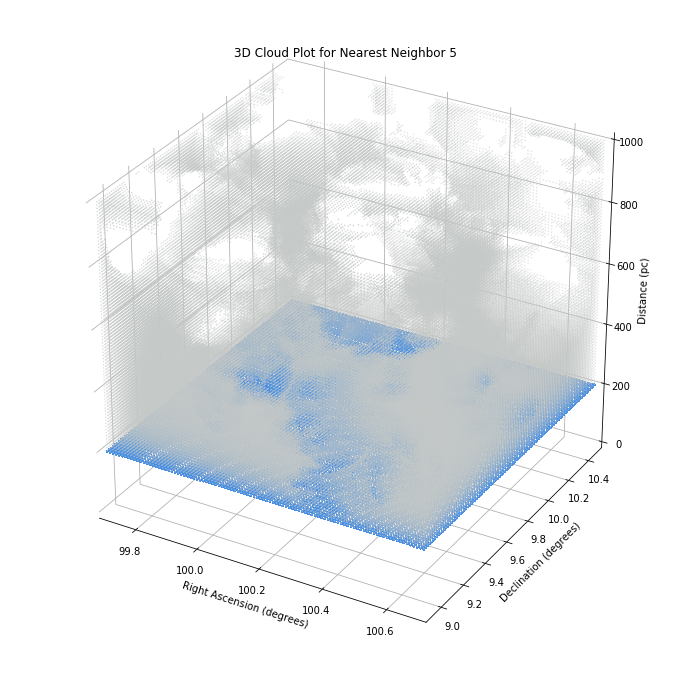

Elapsed Time: 258.6754581928253 seconds
Elapsed Time: 4.311257636547088 minutes


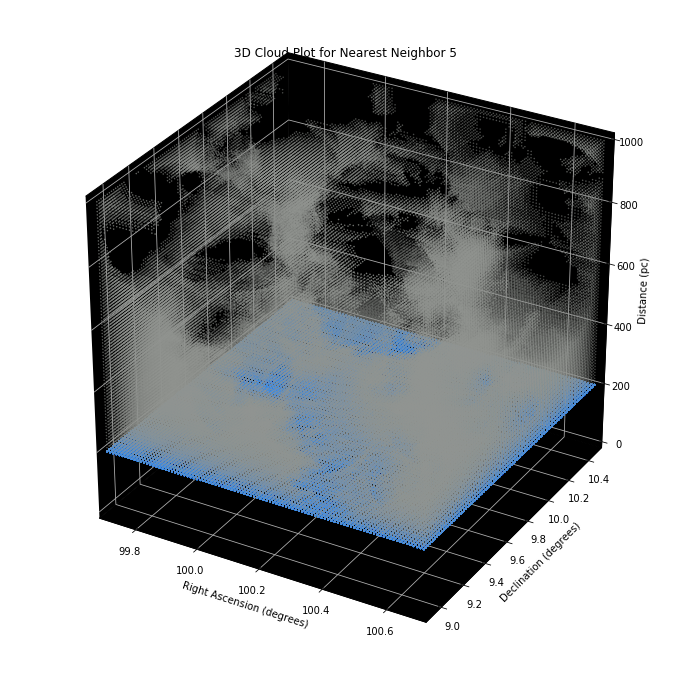

Elapsed Time: 259.7204945087433 seconds
Elapsed Time: 4.328674908479055 minutes


In [58]:
def CloudPlot(BackgroundColor):
    #Plots the three-dimensional "surface" and interior of supposed clouds for the given region of the sky
    #Parameter BackgroundColor is the plot's plane colors (theme) and must be a string; currently supported entries are 'black'
    #and 'white'
    tic=time.time()
    #Gets the starting time
    Distance3DMed=numpy.median(Distances3D)
    Distance3DAvg=numpy.average(Distances3D)
    #Computes the median and average of the kth nearest neighbor three-dimensional distance
    Cloudx=numpy.array([])
    Cloudy=numpy.array([])
    Cloudz=numpy.array([])
    #Makes empty arrays for the next step
    for i in range(0,len(Distances3D)):
        if Distances3D[i]>=Distance3DAvg and Z[i]>=200:
            Cloudx=numpy.append(Cloudx,X[i])
            Cloudy=numpy.append(Cloudy,Y[i])
            Cloudz=numpy.append(Cloudz,Z[i])
    #Adds to the RA, declination, and distance arrays if the kth nearest neighbor distance is equal to or greater than the
    #average 3D distance and the distance is equal or greater than 200 pc (assumes there is negligible extinction or clouds
    #within 200 pc)
    fig=plt.figure()
    ax=plt.axes(projection='3d')
    #Sets up a figure and establishes the settings as three-dimensional
    plt.rcParams['axes.facecolor']='white'
    #Sets figure background color
    ax.scatter3D(X,Y,200,color='xkcd:dark sky blue',marker='o',s=1,depthshade=True)
    #Makes a plane at a distance of 200 pc from Earth to partition off clouds from region of no assumed extinction/clouds
    if BackgroundColor=='black':
        ax.w_xaxis.set_pane_color((0,0,0,1))
        ax.w_yaxis.set_pane_color((0,0,0,1))
        ax.w_zaxis.set_pane_color((0,0,0,1))
        ax.scatter3D(Cloudx,Cloudy,Cloudz,color='xkcd:grey',marker='o',s=0.25,depthshade=True)
        #Makes scatter plot in grey to show the structure of the clouds ("surface" and interior)
    if BackgroundColor=='white':
        ax.w_xaxis.set_pane_color((1,1,1,1))
        ax.w_yaxis.set_pane_color((1,1,1,1))
        ax.w_zaxis.set_pane_color((1,1,1,1))
        ax.scatter3D(Cloudx,Cloudy,Cloudz,color='xkcd:silver',marker='o',s=0.25,depthshade=True)
        #Makes scatter plot in silver to show the structure of the clouds ("surface" and interior)
    #Takes the color input parameter and changes the plot settings accordingly
    plt.title('3D Cloud Plot for Nearest Neighbor %g'%(k))
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_xlim([RAMin,RAMax])
    ax.set_ylabel('Declination (degrees)')
    ax.set_ylim([DecMin,DecMax])
    ax.set_zlabel('Distance (pc)')
    ax.set_zlim([DistanceMin,DistanceMax])
    #Makes appropriate title, axis labels, and limits for variables
    plt.show()
    toc=time.time()
    #Gets final time
    ElapsedTime=toc-tic
    ElapsedTimeMinutes=ElapsedTime/60
    print('Elapsed Time:',ElapsedTime,'seconds')
    print('Elapsed Time:',ElapsedTimeMinutes,'minutes')
    #Shows how long the function took to run
    return (Distance3DMed,Distance3DAvg,Cloudx,Cloudy,Cloudz)
BackgroundColor='white'
Distance3DMed,Distance3DAvg,Cloudx,Cloudy,Cloudz=CloudPlot(BackgroundColor)
#Runs the function with a white background
BackgroundColor='black'
Distance3DMed,Distance3DAvg,Cloudx,Cloudy,Cloudz=CloudPlot(BackgroundColor)
#Runs the function with a black background

In [75]:
print(min(Cloudz))
print(max(Cloudz))
print(numpy.average(Distances3D))
print(numpy.median(Distances3D))

202.02020202020202
1000.0
0.6460305777392727
0.5965089268369809


TypeError: contourf() missing 1 required positional argument: 'Z'

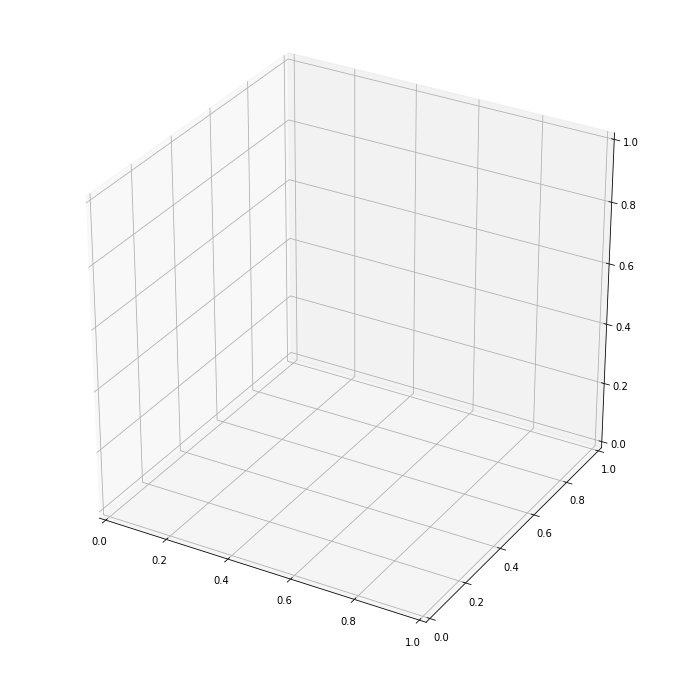

In [77]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
plt.rcParams['figure.figsize']=12,12
plt.rcParams['axes.facecolor']='white'
Axes3D.contourf(X,Y,Z,zdir='z')
plt.show()

In [78]:
'''grey, greyish, cool grey, silver'''

'grey, greyish, cool grey, silver'

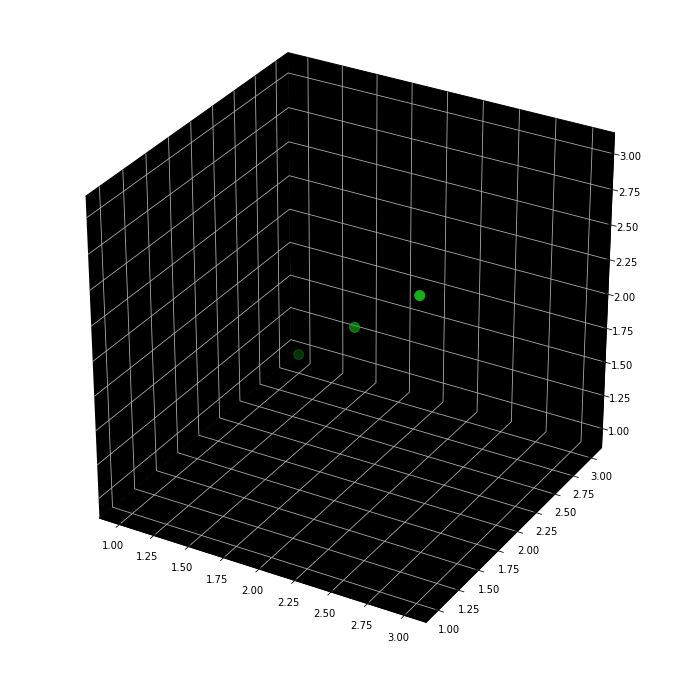

In [80]:
fig=plt.figure()
ax=plt.axes(projection='3d')
plt.rcParams['figure.figsize']=12,12
plt.rcParams['axes.facecolor']='white'
ax.w_xaxis.set_pane_color((0,0,0,1))
ax.w_yaxis.set_pane_color((0,0,0,1))
ax.w_zaxis.set_pane_color((0,0,0,1))
a=[3,2,1]
b=[1,2,3]
c=[3,2,1]
ax.scatter3D(a,b,c,color='xkcd:green',marker='o',s=100,depthshade=True)
plt.show()

In [ ]:
'''fig=plt.figure()
    ax=plt.axes(projection='3d')
    #Creates a new figure and reestablishes 3D axis settings
    plt.rcParams['figure.figsize']=12,12
    plt.rcParams['axes.facecolor']='white'
    ax.scatter3D(StarRA,StarDec,StarDistance,c='xkcd:red',marker='o',s=20,depthshade=True)
    #Plots the three-dimensional positions of all stars in red with varying opacity to show depth
    plt.title('3D Star Locations Plot')
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_xlim([RAMin,RAMax])
    ax.set_ylabel('Declination (degrees)')
    ax.set_ylim([DecMin,DecMax])
    ax.set_zlabel('Distance (pc)')
    ax.set_zlim([DistanceMin,DistanceMax])
    #Makes appropriate limit, axis labels, and title
    plt.show()'''